In [1]:
import pymc as pm
import pandas as pd
import itertools as itt
import arviz as az
import graphviz
import numpy as np
import importlib as imp
from collections import defaultdict
import data_utils
import pickle
from pathlib import Path
import pytensor as pt

import sys
sys.path.append("../")

from models import OneAdvantage
from models import TeamSpecificAdvantage


DB_PATH = '../data/data.sqlite_2023.db'
STORAGE_PATH = '../storage/'

In [2]:
imp.reload(data_utils)
all_games = data_utils.get_data(DB_PATH)
all_games['month'] = (pd.to_datetime(all_games['date']).truncate().dt.to_period('M') - pd.to_datetime(
    all_games['date']
).truncate().dt.to_period('M').min()).apply(lambda x: str(x.n))

all_games

,season_id,home-points,away-points,home-team-id,away-team-id,home-team,away-team,start-year,Regular,date,pair_id,is_home,score_diff,month
0,18743,92,85,10,4,7bet-Lietkabelis,Uniclub Casino - Juventus,2017,1,2017-09-19 00:00:00,"(10, 4)",1,7,298
1,18743,82,73,12,4,Šiauliai,Uniclub Casino - Juventus,2017,1,2017-09-26 00:00:00,"(12, 4)",1,9,298
2,18743,105,84,6,9,Rytas,Wolves,2017,1,2018-01-27 00:00:00,"(9, 6)",-1,-21,302
3,18743,83,78,5,10,Neptūnas,7bet-Lietkabelis,2017,1,2018-01-27 00:00:00,"(10, 5)",-1,-5,302
4,30527,66,76,7,6,Pieno žvaigždės,Rytas,2021,1,2021-09-18 00:00:00,"(7, 6)",1,-10,346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5423,28293,70,92,6,3,Rytas,Žalgiris,2020,1,2021-06-05 00:00:00,"(6, 3)",1,-22,343
5424,28293,112,82,10,4,7bet-Lietkabelis,Uniclub Casino - Juventus,2020,1,2021-06-06 00:00:00,"(10, 4)",1,30,343
5425,28293,84,73,3,6,Žalgiris,Rytas,2020,1,2021-06-07 00:00:00,"(6, 3)",-1,-11,343
5426,28293,83,79,4,10,Uniclub Casino - Juventus,7bet-Lietkabelis,2020,1,2021-06-09 00:00:00,"(10, 4)",-1,-4,343


In [ ]:
T = np.zeros((len(ateams),len(ateams)))
T[range(len(ateams)), range(len(ateams))] =1
team_indicators= T.repeat(len(seasons), axis=0)

season_indicators = np.tile(np.unique(season_idx), len(ateams)).reshape(-1, 1)
seasons_and_teams = np.concatenate([season_indicators, team_indicators], axis=1)

seasons_and_teams[:,0].reshape(27, 28)

In [ ]:

with pm.Model(
    coords = {
        'pairs': pairs,
        'teams': ateams,
        'seasons': seasons
    }
) as pymcGP:
    
    #home court advantage
    β_h = pm.Normal("HC", 4, 2)
    Z_b = pm.Normal("offsets", 0, 1, dims=("teams"))
    σ_b = pm.HalfCauchy("σ", 2)
    β = pm.Deterministic("HC-adv", β_h + Z_b*σ_b, dims=('teams'))

    #error term
    ε = pm.HalfCauchy('error', 5, dims='seasons')

    # GP priors
    ls = 1 / (2 * pm.Exponential("ls_team", 1.0, shape=len(ateams) + 1))
    η = pm.Exponential("η_squared", 1.0)

    #getting the covariances
    cov_func = η * pm.gp.cov.ExpQuad(len(ateams) + 1, ls=ls)
    gp = pm.gp.Latent(cov_func=cov_func)
    f = gp.prior("f", X=seasons_and_teams)    
    
    #GP for the team strength
    baseline_a = pt.tensor.expand_dims(pm.Normal('baseline_str', all_priors, 5, dims=('teams')), 1)    
    
    α = pm.Deterministic(
        "Team-strength", 
        f.reshape((len(ateams), len(seasons))) + baseline_a,
        dims=('teams', 'seasons')
    )    

    S = α[home_team_idx, season_idx] - α[away_team_idx, season_idx] + β[home_team_idx]
    
    pm.Normal('scores', mu=S, sigma=ε[season_idx], observed=score_diffs)

models['pyMC GP'] = pymcGP
pm.model_to_graphviz(pymcGP)

In [ ]:
class CorrelatedExpQuad(pm.gp.cov.Stationary):
    def __init__(self, input_dim, ls=None, ls_inv=None, active_dims=None, eta=1, corr_ls=None, elems=None):
        super().__init__(input_dim=input_dim, active_dims=active_dims, ls=ls, ls_inv=ls_inv)        
        
        self.eta = pt.tensor.as_tensor_variable(eta)
        if corr_ls is not None:
            self.corr_ls = pt.tensor.as_tensor_variable(corr_ls)
            self.one_of_k = pt.tensor.as_tensor_variable(np.diag(np.ones(elems)))

    def square_dist(self, X, Xs):        
        if Xs is None:
            s = pt.tensor.square(X).sum(axis=-1)
            sqd = -2 * pt.tensor.matmul(
                X, X.transpose(0, 2, 1)
            ) + pt.tensor.expand_dims(s, -2) + pt.tensor.expand_dims(s, -1)
        else:
            raise NotImplementedError
        return pt.tensor.clip(sqd, 0.0, np.inf)
        
    def full(self, X, Xs=None):        
        cov_kernels = self.cov_kernel(X, Xs)
        corr_kernel = self.corr_kernel()        
        return pt.tensor.tensordot(
            corr_kernel[:, None, None], 
            cov_kernels, 
            axes=[0,0]
        ).squeeze()

    def quad_kernel(self, X, Xs, ls):
        return pt.tensor.exp(-0.5 * self.square_dist(X, Xs) / ls)
        
    def cov_kernel(self, X, Xs):
        return pt.tensor.mul(
            self.quad_kernel(X, Xs, self.ls),
            self.eta
        )
    
    def corr_kernel(self):
        return self.quad_kernel(
            X=pt.tensor.expand_dims(self.one_of_k, 0), 
            Xs=None,
            ls = self.corr_ls
        ).squeeze()    


In [3]:
games = all_games[all_games['start-year'] >= 2010]
#games = games[
#    games['home-team'].isin(('Žalgiris', 'Rytas', 'Lietkabelis', 'Labas Gas')) &
#    games['away-team'].isin(('Žalgiris', 'Rytas', 'Lietkabelis', 'Labas Gas'))
#    ]


team_idx, teams = pd.factorize(games['home-team'], sort=True)
season_idx, seasons = pd.factorize(games['month'], sort=True)
game_type_idx, _ = pd.factorize(games['Regular'], sort=True)
game_idx = games.index.values
game_type = ['Playoffs', 'Regular season']
score_diffs = (games['home-points'] - games['away-points']).values
home_team_idx, hteams = pd.factorize(games['home-team'], sort=True)
away_team_idx, ateams = pd.factorize(games['away-team'], sort=True)

assert(set(teams) == set(hteams))
assert(set(teams) == set(ateams))

season_indicators = np.tile(np.sort(np.unique(season_idx)).reshape(-1, 1), (len(teams), 1, 1))

In [4]:

no_seasons = 4
no_teams = 3

base_array = np.array(range(no_seasons)).reshape(-1, 1)
S = np.tile(base_array, (no_teams, 1, 1))
ls = np.array(np.arange(no_teams) + 1).reshape(no_teams, 1, 1)
#ls = np.ones_like(ls)

eta = np.array(np.arange(no_teams) + 1).reshape(no_teams, 1, 1)
eta = np.ones_like(eta)
corr_elems = (np.arange(no_teams) + 0.1).reshape(-1, 1)

In [5]:
class CorrelatedExpQuad(pm.gp.cov.Stationary):
    def __init__(self, ls=None, ls_inv=None, active_dims=None, eta=1, corr_ls=None, elems=None):
        super().__init__(input_dim=1, active_dims=active_dims, ls=ls, ls_inv=ls_inv)        
        
        self.eta = pt.tensor.as_tensor_variable(eta)
        if corr_ls is not None:
            self.corr_ls = pt.tensor.as_tensor_variable(corr_ls)
            self.one_of_k = pt.tensor.as_tensor_variable(np.diag(np.ones(elems)))

    def square_dist(self, X, Xs):        
        if Xs is None:
            s = pt.tensor.square(X).sum(axis=-1)
            sqd = -2 * pt.tensor.matmul(
                X, X.transpose(0, 2, 1)
            ) + pt.tensor.expand_dims(s, -2) + pt.tensor.expand_dims(s, -1)
        else:
            raise NotImplementedError
        return pt.tensor.clip(sqd, 0.0, np.inf)
        
    def full(self, X, Xs=None):        
        cov_kernels = self.cov_kernel(X, Xs)
        corr_kernel = self.corr_kernel()        
        return pt.tensor.tensordot(
            corr_kernel[:, None, None], 
            cov_kernels, 
            axes=[0,0]
        ).squeeze()

    def quad_kernel(self, X, Xs, ls):
        return pt.tensor.exp(-0.5 * self.square_dist(X, Xs) / ls)
        
    def cov_kernel(self, X, Xs):
        K = self.quad_kernel(X, Xs, self.ls)
        result, _ = pt.scan(
            fn=lambda A: A + (1e-6 * pt.tensor.identity_like(A)),     
            sequences=K
        )
        
        return pt.tensor.mul(
            result,
            self.eta
        )
    
    def corr_kernel(self):
        return self.quad_kernel(
            X=pt.tensor.expand_dims(self.one_of_k, 0), 
            Xs=None,
            ls = self.corr_ls
        ).squeeze()    


In [6]:
pt.tensor.diag(pt.tensor.ones_like(pt.tensor.as_tensor_variable(np.ones((3,4,4))))).eval()

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [7]:
cov_func = CorrelatedExpQuad(    
    ls=np.ones((len(teams), 1, 1)), 
    eta=np.ones((len(teams), 1, 1)), 
    elems=len(teams), 
    corr_ls=np.ones((len(teams)))
)
cov_func.full(season_indicators).eval()

array([[[10.93275584,  6.63104498,  1.47958613, ...,  0.        ,
          0.        ,  0.        ],
        [ 6.63104498, 10.93275584,  6.63104498, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.47958613,  6.63104498, 10.93275584, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 10.93275584,
          6.63104498,  1.47958613],
        [ 0.        ,  0.        ,  0.        , ...,  6.63104498,
         10.93275584,  6.63104498],
        [ 0.        ,  0.        ,  0.        , ...,  1.47958613,
          6.63104498, 10.93275584]],

       [[10.93275584,  6.63104498,  1.47958613, ...,  0.        ,
          0.        ,  0.        ],
        [ 6.63104498, 10.93275584,  6.63104498, ...,  0.        ,
          0.        ,  0.        ],
        [ 1.47958613,  6.63104498, 10.93275584, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., 1

In [8]:
cov_func = CorrelatedExpQuad(    
    ls=ls, 
    eta=eta, 
    elems=no_teams, 
    corr_ls=corr_elems
)
final_covs = cov_func.full(S, None)
pm.gp.util.cholesky(final_covs[0]).eval()

array([[1.42268672, 0.        , 0.        , 0.        ],
       [1.01645005, 0.99542293, 0.        , 0.        ],
       [0.42346421, 1.02032989, 0.89646109, 0.        ],
       [0.13507509, 0.46729868, 1.01743591, 0.86732251]])

In [9]:
result, _ = pt.scan(
    fn=lambda A: pm.gp.util.cholesky(A),     
    sequences=pt.tensor.as_tensor_variable(final_covs)
)

Zs = pm.Normal.dist(mu=0, sigma=1, shape=(no_teams, no_seasons))

In [10]:

pt.tensor.batched_dot(result, Zs).eval().shape


(3, 4)

In [11]:
chols = result.eval()
chols.shape

(3, 4, 4)

In [12]:
Zscores = Zs.eval()
Zscores.shape

(3, 4)

In [13]:
np.array([np.dot(c, z) for c,z in zip(chols, Zscores)])

array([[ 1.0311903 ,  1.26499943,  1.11289012,  0.0054771 ],
       [ 2.53041178,  1.42527492, -0.16368832, -1.00113308],
       [-1.82705145, -0.0302825 ,  1.33740003,  1.36121265]])

In [14]:
(chols @ np.expand_dims(Zscores,2)).squeeze(2)

array([[ 1.0311903 ,  1.26499943,  1.11289012,  0.0054771 ],
       [ 2.53041178,  1.42527492, -0.16368832, -1.00113308],
       [-1.82705145, -0.0302825 ,  1.33740003,  1.36121265]])

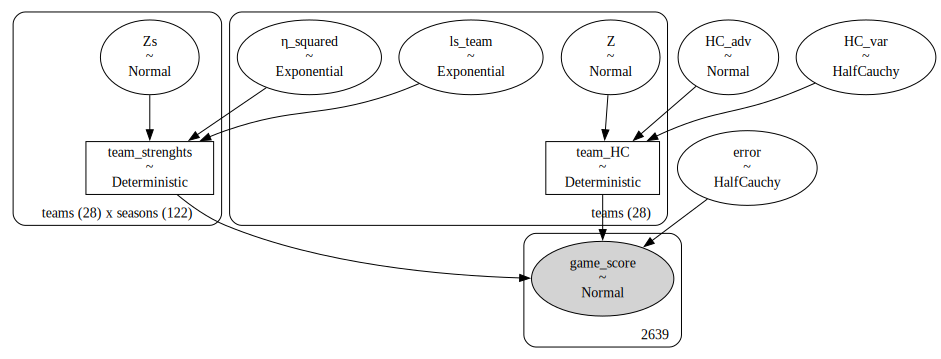

In [15]:
with pm.Model(
    coords={
        'teams': teams,
        "home_teams": teams,
        "away_teams": teams,
        'seasons': seasons,
        'games': game_idx
    }
) as m:
    
    
    ls_team = (1 / (pm.Exponential("ls_team", 1, dims="teams")))[:, None, None] 
        
    η = pm.Exponential("η_squared", 1, dims='teams')[:, None, None] 
        
    #ls_corr = (1 / (2* pm.Exponential("team_corr", 2, dims="teams")))
        
    cov_func = CorrelatedExpQuad(ls=ls_team, eta=η, corr_ls=None, elems=None)
    covariances = cov_func.cov_kernel(X=season_indicators, Xs=None)


    chols, _ = pt.scan(
        fn=lambda C: pm.gp.util.cholesky(C),     
        sequences=covariances
    )

    Zs = pm.Normal("Zs", mu=0, sigma=1, dims=('teams', 'seasons'))
    team_strengths = pm.Deterministic(
        "team_strenghts", 
        pt.tensor.batched_dot(chols, Zs), 
        dims=("teams", "seasons")
    )


    home_court_adv = pm.Normal("HC_adv", 0, 2)
    s = pm.HalfCauchy("HC_var", 1)
    Z = pm.Normal("Z", 0, 1, dims="teams")
    team_HC = pm.Deterministic("team_HC", home_court_adv + s*Z, dims="teams")
    #team_strength = pm.Normal("team_strength", 0, 5, dims=("seasons", "teams"))

    #predicted_diff = team_strength[season_idx, home_team_idx] + team_HC[home_team_idx] - team_strength[season_idx, away_team_idx]
    predicted_diff = team_strengths[home_team_idx, season_idx] + team_HC[home_team_idx] - team_strengths[away_team_idx, season_idx]
    err = pm.HalfCauchy("error", 1)
    
    pm.Normal("game_score", mu=predicted_diff, sigma=err, observed=score_diffs)

pm.model_to_graphviz(m)

In [16]:
with m:
    prior_pc = pm.sample_prior_predictive()

Sampling: [HC_adv, HC_var, Z, Zs, error, game_score, ls_team, η_squared]


KeyboardInterrupt: 

In [19]:
import altair as alt
alt.Chart(
    prior_pc['prior']['team_strenghts'].mean(dim=['chain', 'draw']).to_dataframe().reset_index()
).mark_line().encode(
    alt.X('seasons:O'), alt.Y('team_strenghts'), alt.Color('teams'),
    alt.Row('teams')
).properties(width=200, height=50)

alt.Chart(...)

In [20]:
with m:
    trace = pm.sample(
        nuts_sampler="blackjax", 
        #target_accept=0.99,
        random_seed=np.random.default_rng(1)
    )

/home/aurimas/micromamba/envs/pymc5/lib/python3.11/site-packages/pymc/sampling/mcmc.py:243: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:03.252574
Sampling...
Sampling time =  0:00:08.908963
Transforming variables...


In [71]:
az.summary(
    trace, var_names=['ls_team', 'η_squared', 'HC_adv'],     
    )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ls_team[7bet-Lietkabelis],0.191,0.553,0.000,1.007,0.015,0.010,671.0,2008.0,1.01
ls_team[CBet],1.017,1.007,0.001,2.931,0.015,0.011,3101.0,2233.0,1.00
ls_team[Gargždai],0.939,0.987,0.000,2.738,0.013,0.010,3434.0,2202.0,1.00
ls_team[Labas Gas],0.729,0.886,0.000,2.349,0.018,0.013,1089.0,1201.0,1.00
ls_team[NEP-2_1009],0.990,0.980,0.000,2.727,0.012,0.011,3709.0,1597.0,1.00
ls_team[Neptūnas],1.048,1.055,0.000,2.996,0.016,0.012,2819.0,2082.0,1.00
ls_team[Nevėžis–Optibet],0.663,0.857,0.000,2.172,0.018,0.013,1134.0,1353.0,1.00
ls_team[Pieno žvaigždės],0.884,0.947,0.001,2.575,0.014,0.010,2606.0,1669.0,1.00
ls_team[Rytas],0.005,0.015,0.000,0.014,0.000,0.000,1323.0,1723.0,1.00
ls_team[SŪD_1020],1.004,1.029,0.000,2.880,0.012,0.012,5121.0,1502.0,1.00


In [72]:
import altair as alt

strengths = trace['posterior']['team_strenghts'].mean(dim=['chain', 'draw']).to_dataframe().reset_index()


alt.Chart(
    strengths[~strengths['teams'].str.contains("_")]
).mark_point().encode(
    alt.X('seasons'),
    alt.Y('team_strenghts'),
    alt.Color("teams"),   
    alt.Tooltip('teams')  
).interactive()

alt.Chart(...)

In [36]:
import altair as alt

hcs = az.summary(trace, var_names='team_HC', fmt='wide').reset_index(names='teams')
hcs = hcs[~hcs['teams'].str.contains("1")]
c = alt.Chart(hcs)

lines = c.mark_point().encode(x=alt.X('teams', sort=alt.EncodingSortField(field="mean", op="min")), y='mean')
cints = c.mark_errorbar().encode(
    x=alt.X('teams', sort=alt.EncodingSortField(field="mean", op="min")), 
    y=alt.Y('hdi_3%'), y2='hdi_97%')

cints + lines


alt.LayerChart(...)

In [22]:
az.summary(
    trace, var_names=['team_strenghts'], coords = {'teams': ['Žalgiris', 'Rytas']}   
    )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"team_strenghts[Žalgiris, 303]",16.828,1.992,13.073,20.637,0.035,0.025,3334.0,3117.0,1.0
"team_strenghts[Žalgiris, 310]",17.021,1.919,13.334,20.605,0.033,0.023,3403.0,3126.0,1.0
"team_strenghts[Žalgiris, 311]",17.200,1.856,13.637,20.656,0.032,0.022,3459.0,2992.0,1.0
"team_strenghts[Žalgiris, 312]",17.365,1.804,13.816,20.695,0.030,0.022,3501.0,3192.0,1.0
"team_strenghts[Žalgiris, 313]",17.516,1.763,14.268,20.997,0.030,0.021,3529.0,3311.0,1.0
...,...,...,...,...,...,...,...,...,...
"team_strenghts[Rytas, 362]",9.886,1.557,7.003,12.822,0.024,0.017,4170.0,3836.0,1.0
"team_strenghts[Rytas, 363]",9.794,1.592,6.774,12.685,0.025,0.018,4162.0,3503.0,1.0
"team_strenghts[Rytas, 364]",9.696,1.633,6.654,12.725,0.025,0.018,4133.0,3542.0,1.0
"team_strenghts[Rytas, 365]",9.593,1.679,6.282,12.539,0.026,0.019,4075.0,3610.0,1.0


In [28]:
dens, edges = np.histogram(trace['posterior']['team_strenghts'].sel(teams='Žalgiris', seasons='303') - 
 trace['posterior']['team_strenghts'].sel(teams='7bet-Lietkabelis', seasons='303'), bins=20, density=True)

alt.Chart(pd.DataFrame({'d': dens, 'e': edges[:-1]})).mark_line().encode(
    x='e', y='d'
)


alt.Chart(...)

array([[<Axes: title={'center': 'team_strenghts'}>,
        <Axes: title={'center': 'team_strenghts'}>]], dtype=object)

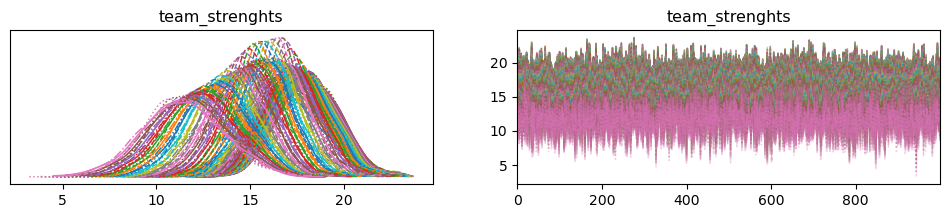

In [29]:
az.plot_trace(trace, var_names=['team_strenghts'], coords={'teams': "Žalgiris"})